#Import the Dataset


In [64]:
!pip install -q dlai-grader==1.20.0 tensorflow==2.18.0 numpy==1.26.4 pandas==2.2.2

In [65]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from utils_transformer import get_train_test_data, preprocess

tf.keras.utils.set_random_seed(10)

In [68]:
train_data, test_data = get_train_test_data(".")

#Preprocess the data

In [69]:
example_summary, example_dialogue = train_data.iloc[10]

print(f"dialogue:\n{example_dialogue}\n")
print(f"summary:\n{example_summary}")

dialogue:
Lucas: Hey! How was your day?
Demi: Hey there! 
Demi: It was pretty fine, actually, thank you!
Demi: I just got promoted! :D
Lucas: Whoa! Great news!
Lucas: Congratulations!
Lucas: Such a success has to be celebrated.
Demi: I agree! :D
Demi: Tonight at Death & Co.?
Lucas: Sure!
Lucas: See you there at 10pm?
Demi: Yeah! See you there! :D

summary:
Demi got promoted. She will celebrate that with Lucas at Death & Co at 10 pm.


In [70]:
summary, document = preprocess(train_data)
summary_test, document_test = preprocess(test_data)

In [71]:
filters = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n'
oov_token = '[UNK]'

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters = filters,
    lower = False,
    oov_token = oov_token
    )

documents_and_summary = pd.concat([document, summary], ignore_index = True)

# create the vocabulary
tokenizer.fit_on_texts(documents_and_summary)

# convert words to vectors
inputs = tokenizer.texts_to_sequences(document)
targets = tokenizer.texts_to_sequences(summary)

vocab_size = len(tokenizer.word_index) + 1

print(f'Size of vocabulary: {vocab_size}')

Size of vocabulary: 34250


In [72]:
encoder_maxlen = 150
decoder_maxlen = 50

# apply padding
inputs = tf.keras.preprocessing.sequence.pad_sequences(
    sequences = inputs,
    maxlen = encoder_maxlen,
    padding = 'post',
    truncating = 'post')

targets = tf.keras.preprocessing.sequence.pad_sequences(
    sequences = targets,
    maxlen = decoder_maxlen,
    padding = 'post',
    truncating = 'post')

In [73]:
# convert vectors to float32
inputs = tf.cast(inputs, tf.float32)
targets = tf.cast(targets, tf.float32)

In [74]:
BUFFER_SIZE = 10000
batch_size = 64

# create the dataset
dataset = tf.data.Dataset.from_tensor_slices(
    tensors = (inputs, targets)).shuffle(BUFFER_SIZE).batch(batch_size)

In [75]:
for i in dataset.take(1):
    print(f"first input sample shape: {i[0].shape}")
    print(f"first target sample shape: {i[1].shape}")

first input sample shape: (64, 150)
first target sample shape: (64, 50)


#Positional Encoding

In [76]:
def positional_encoding(positions, d_model):

    position = np.arange(positions)[:, np.newaxis]
    k = np.arange(d_model)[np.newaxis, :]
    i = k // 2

    # initialize a matrix angle_rads of all the angles
    angle_rates = 1 / np.power(10000, (2 * i) / np.float32(d_model))
    angle_rads = position * angle_rates

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

#Masking


In [77]:
def create_padding_mask(decoder_token_ids):

    "Creates a matrix mask for the padding cells"

    seq = 1 - tf.cast(tf.equal(decoder_token_ids, 0), decoder_token_ids.dtype)

    return seq[:, tf.newaxis, :]

In [78]:
create_padding_mask(tf.constant([[1,2,0],
                                 [3,0,0]],dtype = tf.float32))

<tf.Tensor: shape=(2, 1, 3), dtype=float32, numpy=
array([[[1., 1., 0.]],

       [[1., 0., 0.]]], dtype=float32)>

In [79]:
def create_look_ahead_mask(sequence_length):

    "Returns a lower triangular matrix filled with ones"

    ones = tf.ones((1, sequence_length, sequence_length))

    # num_lower = -1 means fill under diagonal with ones,
    # num_upper = 0 means let upper the diagonal with zeros
    return tf.linalg.band_part(ones, num_lower = -1, num_upper = 0)

In [80]:
a = tf.constant([[1,2,0], [3,0,0], [1,2,1]], dtype = tf.float32)

create_look_ahead_mask(a.shape[-2])

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]], dtype=float32)>

#self-attention

In [81]:
def scaled_dot_product_attention(q, k, v, mask):

    align = tf.matmul(q, k, transpose_b = True)

    dk = tf.cast(k.shape[-1], align.dtype)
    scaled_align = align / tf.math.sqrt(dk)

    # musk should be applied before softmax
    if mask is not None:
        scaled_align += (1.0 - mask) * -1e9

    weights = tf.nn.softmax(scaled_align)

    context = tf.matmul(weights, v)

    return context, weights

In [82]:
q = tf.constant([[1,2,0], [3,0,0], [1,2,1]], dtype = tf.float32)

k = tf.constant([[1,2,0], [3,0,0], [1,2,1]], dtype = tf.float32)

v = tf.constant([[1,2,0], [3,0,0], [1,2,1]], dtype = tf.float32)

scaled_dot_product_attention(q, k, v, None)

(<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[1.2722516 , 1.7277484 , 0.4319371 ],
        [2.8821719 , 0.11782812, 0.02945703],
        [1.203556  , 1.7964439 , 0.57527304]], dtype=float32)>,
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[0.4319371 , 0.1361258 , 0.4319371 ],
        [0.02945703, 0.9410859 , 0.02945703],
        [0.32294896, 0.10177799, 0.57527304]], dtype=float32)>)

In [83]:
# Testing the function
q = np.array([[1, 1, 0, 1],
              [0, 1, 1, 1],
              [1, 0, 1, 1]]).astype(np.float32)

k = np.array([[1, 1, 0, 1],
              [1, 0, 1, 1],
              [1, 1, 1, 0],
              [0, 0, 0, 1],
              [0, 1, 0, 1]]).astype(np.float32)

v = np.array([[0, 0],
              [1, 0],
              [1, 0],
              [1, 1],
              [1, 1]]).astype(np.float32)

mask = np.array([[[0, 1, 0, 1, 1],
                  [1, 0, 0, 1, 1],
                  [1, 1, 0, 1, 1]]])

ou, atw = scaled_dot_product_attention(q, k, v, mask)
ou = np.around(ou, decimals=2)
atw = np.around(atw, decimals=2)

print(f"Output:\n {ou}")
print(f"\nAttention weigths:\n {atw}")

Output:
 [[[1.   0.62]
  [0.62 0.62]
  [0.74 0.31]]]

Attention weigths:
 [[[0.   0.38 0.   0.23 0.38]
  [0.38 0.   0.   0.23 0.38]
  [0.26 0.43 0.   0.16 0.16]]]


#Encoder

In [85]:
def FullyConnected(embedding_dim, fully_connected_dim):

    ffnn = tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),
        tf.keras.layers.Dense(embedding_dim)])

    return ffnn

In [86]:
class EncoderLayer(tf.keras.layers.Layer):

    def __init__(self, num_heads, embedding_dim,
                 fully_connected_dim, dropout_rate = 0.1,
                 layernorm_eps = 1e-6):

        super().__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(
                num_heads = num_heads,
                key_dim = embedding_dim,
                dropout = dropout_rate,
            )

        self.ffn = FullyConnected(
                embedding_dim,
                fully_connected_dim
            )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon = layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon = layernorm_eps)

        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)

    def __call__(self, x, is_training, mask):

        # since we are in encoder, use the same i/p for qkv
        self_mha_output = self.mha(
            query = x, key = x, value = x, attention_mask = mask)

        # residual connection and normalization
        skip_x_attention = self.layernorm1(x + self_mha_output)

        # feed forward nn
        ffn_output = self.ffn(skip_x_attention)

        # apply dropout just for training
        ffn_output = self.dropout_ffn(ffn_output, training = is_training)

        # another residual connection and normalization
        encoder_layer_out = self.layernorm2(skip_x_attention + ffn_output)

        return encoder_layer_out

In [87]:
x = tf.random.uniform((1,3,5))

E = EncoderLayer(num_heads = 1,
                 embedding_dim = 5,
                 fully_connected_dim= 120)

E(x = x, is_training = True, mask = None)

<tf.Tensor: shape=(1, 3, 5), dtype=float32, numpy=
array([[[ 0.7081839 ,  0.41457322, -1.5866754 ,  1.1543071 ,
         -0.6903888 ],
        [ 1.313329  , -0.37334985, -1.6875824 ,  0.30907148,
          0.43853182],
        [ 1.1260601 , -0.1944412 , -0.70851934,  1.1468799 ,
         -1.3699793 ]]], dtype=float32)>

In [88]:
class Encoder(tf.keras.layers.Layer):

    """
      the full encoder starts with passing the i/p to embedding layer
      and ends with a contextual representation for the sequance
    """

    def __init__(self, num_layers, vocab_size,
                 embedding_dim, maximum_position_encoding,
                 num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):

        super().__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(
            input_dim = vocab_size,
            output_dim = embedding_dim,
            mask_zero = True # ignaoring 0 in calcualtions
        )

        self.pos_encoding = positional_encoding(
            maximum_position_encoding,
            embedding_dim
        )

        # repreating encoder layer for certain num of layers
        self.enc_layer = [
            EncoderLayer(num_heads,
                         embedding_dim,
                         fully_connected_dim,
                         dropout_rate,
                         layernorm_eps)

            for _ in range(num_layers)
            ]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, is_training, mask):

        seq_len = tf.shape(x)[1]

        x = self.embedding(x)

        # this scaling process helps maintain a good balance between
        # the learned embeddings and the fixed positional encodings
        # because the embedding is a slightly smaller than the positional encoding values
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        # add positional encoding values
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=is_training)

        # iterate over encoder layer for n times
        for i in range(self.num_layers):
            x = self.enc_layer[i](x, is_training, mask)

        return x # (batch_size, input_seq_len, embedding_dim)

In [89]:
x = tf.random.uniform((1,2))

E = Encoder(num_layers=2, vocab_size=vocab_size,
                 embedding_dim=10,maximum_position_encoding=100,
                 num_heads=8, fully_connected_dim=150,
                 dropout_rate=0.1, layernorm_eps=1e-6)

encoder_out = E(x, is_training = True, mask= None)
encoder_out

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'encoder_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


<tf.Tensor: shape=(1, 2, 10), dtype=float32, numpy=
array([[[-0.30631414,  1.0099329 , -1.2527146 ,  0.72792435,
         -0.4140447 ,  0.3989549 , -1.2532282 ,  0.41933027,
         -1.162495  ,  1.8326545 ],
        [-0.20135403, -0.26914924, -0.4888366 ,  0.5466636 ,
         -0.6971479 ,  0.9217518 , -1.1409347 ,  0.2441242 ,
         -1.1987865 ,  2.2836695 ]]], dtype=float32)>

#Decoder

In [90]:
class DecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate = 0.1, layernorm_eps = 1e-6):

        super().__init__()

        self.mha1 = tf.keras.layers.MultiHeadAttention(
            num_heads = num_heads,
            key_dim = embedding_dim,
            dropout = dropout_rate
        )

        self.mha2 = tf.keras.layers.MultiHeadAttention(
            num_heads = num_heads,
            key_dim = embedding_dim,
            dropout = dropout_rate
        )

        self.ffn = FullyConnected(
            embedding_dim,
            fully_connected_dim
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(
            epsilon = layernorm_eps
        )

        self.layernorm2 = tf.keras.layers.LayerNormalization(
            epsilon = layernorm_eps
        )

        self.layernorm3 = tf.keras.layers.LayerNormalization(
            epsilon = layernorm_eps
        )

        self.dropout = tf.keras.layers.Dropout(
            rate = dropout_rate
        )

    def call(self, x, encoder_output, is_training,
             look_ahead_mask, padding_mask):

        # masked multi head attention layer
        multi_attn_out_1, masked_attention_weights = self.mha1(
            query = x,
            key = x,
            value = x,
            attention_mask = look_ahead_mask,
            return_attention_scores = True
        )

        # first residual connection and layer norm
        norm_layer_out_1 = self.layernorm1(multi_attn_out_1 + x)

        # multi head attention layer
        multi_attn_out_2, attention_weights = self.mha2(
            query = norm_layer_out_1,
            key = encoder_output,
            value = encoder_output,
            attention_mask = padding_mask,
            return_attention_scores=True
        )

        # second residual connection and layer norm
        norm_layer_out_2 = self.layernorm2(multi_attn_out_2 + norm_layer_out_1)

        # feed forward nn
        ffn_output = self.ffn(norm_layer_out_2)

        # dropout layer
        ffn_output = self.dropout(ffn_output, training = is_training)

        output = self.layernorm3(ffn_output + norm_layer_out_2)

        return output, masked_attention_weights, attention_weights

In [91]:
q = tf.random.uniform((1,3,5))

dec = DecoderLayer(num_heads = 1,
                 embedding_dim = 5,
                 fully_connected_dim = 120)

dec_out, masked_attn_weights, attn_weights = dec(q,
                                                 encoder_output = encoder_out,
                                                 is_training = True,
                                                 look_ahead_mask = None,
                                                 padding_mask = None)

print(f"q has shape:{q.shape}")
print(f"Output of encoder has shape:{encoder_out.shape}\n")
print(f"Output of decoder layer has shape:{dec_out.shape}")
print(f"masked attetion Weights has shape:{masked_attn_weights.shape}")
print(f"attetion Weights has shape:{attn_weights.shape}")

q has shape:(1, 3, 5)
Output of encoder has shape:(1, 2, 10)

Output of decoder layer has shape:(1, 3, 5)
masked attetion Weights has shape:(1, 1, 3, 3)
attetion Weights has shape:(1, 1, 3, 2)


In [92]:
class Decoder(tf.keras.layers.Layer):

    "full decoder"

    def __init__(self,num_layers,embedding_dim,num_heads,
                      fully_connected_dim,target_vocab_size,
                      maximum_position_encoding,
                      dropout_rate=0.1, layernorm_eps=1e-6):

        super().__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(
            input_dim = target_vocab_size,
            output_dim = self.embedding_dim
        )

        self.pos_encoding = positional_encoding(
            positions = maximum_position_encoding,
            d_model = self.embedding_dim
        )

        # repreating decoder layer for certain num of layers
        self.decoder_layers = [
            DecoderLayer(
                self.embedding_dim,
                num_heads, fully_connected_dim,
                dropout_rate=0.1, layernorm_eps=1e-06)

            for _ in range(self.num_layers)
            ]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, encoder_output, is_training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        all_attention_weights = {}

        x = self.embedding(x)

        # this scaling process helps maintain a good balance between
        # the learned embeddings and the fixed positional encodings
        # because the embedding is a slightly smaller than the positional encoding values
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        # add positional encoding
        x += self.pos_encoding[:,:seq_len, :]

        x = self.dropout(x, training = is_training)

        for i in range(self.num_layers):
            x, masked_attention_weights, attention_weights = self.decoder_layers[i](
                x, encoder_output, is_training = is_training,
                look_ahead_mask = look_ahead_mask,
                padding_mask = padding_mask
            )

        all_attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = masked_attention_weights
        all_attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = attention_weights

        return x, all_attention_weights

In [93]:
# Test your function!
n_layers = 5
emb_d = 13
n_heads = 17
fully_connected_dim = 16
target_vocab_size = 300
maximum_position_encoding = 6

x = np.array([[3, 2, 1, 1], [2, 1, 1, 0], [2, 1, 1, 0]])

encoder_test_output = tf.convert_to_tensor(np.random.rand(3, 7, 9))

look_ahead_mask = create_look_ahead_mask(x.shape[1])

decoder_test = Decoder(
    n_layers, emb_d, n_heads, fully_connected_dim, target_vocab_size,maximum_position_encoding)

outd, att_weights = decoder_test(
    x, encoder_test_output, is_training = False, look_ahead_mask = look_ahead_mask, padding_mask = None)

print(f"Using num_layers={n_layers}, embedding_dim={emb_d} and num_heads={n_heads}:\n")
print(f"x has shape:{x.shape}")
print(f"Output of encoder has shape:{encoder_test_output.shape}\n")

print(f"Output of decoder has shape:{outd.shape}\n")

print("Attention weights:")
for name, tensor in att_weights.items():
    print(f"{name} has shape:{tensor.shape}")

Using num_layers=5, embedding_dim=13 and num_heads=17:

x has shape:(3, 4)
Output of encoder has shape:(3, 7, 9)

Output of decoder has shape:(3, 4, 13)

Attention weights:
decoder_layer5_block1_self_att has shape:(3, 17, 4, 4)
decoder_layer5_block2_decenc_att has shape:(3, 17, 4, 7)


#Transformer

In [94]:
class Transformer(tf.keras.Model):

    def __init__(self,
                 num_layers,
                 input_vocab_size,
                 target_vocab_size,
                 embedding_dim,
                 maximum_position_encoding_input,
                 maximum_position_encoding_target,
                 num_heads,
                 fully_connected_dim,
                 dropout_rate=0.1,
                 layernorm_eps=1e-06):

        super().__init__()

        self.encoder = Encoder(num_layers = num_layers,
                               vocab_size = input_vocab_size,
                               embedding_dim = embedding_dim,
                               maximum_position_encoding = maximum_position_encoding_input,
                               num_heads = num_heads,
                               fully_connected_dim = fully_connected_dim,
                               dropout_rate = dropout_rate,
                               layernorm_eps = layernorm_eps
        )

        self.decoder = Decoder(num_layers = num_layers,
                               embedding_dim = embedding_dim,
                               num_heads = num_heads,
                               fully_connected_dim = fully_connected_dim,
                               target_vocab_size = target_vocab_size,
                               maximum_position_encoding = maximum_position_encoding_target,
                               dropout_rate = dropout_rate,
                               layernorm_eps = layernorm_eps
        )



        self.fc = tf.keras.layers.Dense(
            target_vocab_size,
            activation = "softmax"
        )


    def call(self,input, target, is_training,
             enc_padding_mask, dec_padding_mask,
             look_ahead_mask):

        enc_out = self.encoder(input,
                               is_training = is_training,
                               mask = enc_padding_mask
        )

        dec_out, _ = self.decoder(target,
                                  enc_out,
                                  is_training = is_training,
                                  look_ahead_mask = look_ahead_mask,
                                  padding_mask = dec_padding_mask
        )

        output = self.fc(dec_out)

        return output

In [95]:
inp = tf.constant([[2, 3, 1, 3, 0, 0, 0]])
tar = tf.constant([[1, 3, 4, 0, 0, 0, 0]])

trans = Transformer(
    num_layers=1,
    input_vocab_size=5,
    target_vocab_size=6,
    embedding_dim=10,
    maximum_position_encoding_input=10,
    maximum_position_encoding_target = 10,
    num_heads=10,
    fully_connected_dim=13
    )

enc_padding_mask = create_padding_mask(inp)
dec_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[1])

trans(inp, tar, is_training = False,
      enc_padding_mask = enc_padding_mask,
      dec_padding_mask = dec_padding_mask,
      look_ahead_mask = look_ahead_mask)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'encoder_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


<tf.Tensor: shape=(1, 7, 6), dtype=float32, numpy=
array([[[0.01487851, 0.20799032, 0.16125268, 0.33717978, 0.07287869,
         0.20582001],
        [0.03978156, 0.20249669, 0.25221854, 0.2504698 , 0.04786408,
         0.20716928],
        [0.06639344, 0.22112691, 0.19102435, 0.27094004, 0.03723403,
         0.21328126],
        [0.07335594, 0.25044033, 0.11506843, 0.30594125, 0.04390745,
         0.21128659],
        [0.06299673, 0.23691863, 0.06678327, 0.35449   , 0.06316341,
         0.21564794],
        [0.04523607, 0.21091118, 0.04452794, 0.3888606 , 0.0956915 ,
         0.21477267],
        [0.05040847, 0.23726067, 0.06002739, 0.32277077, 0.11378585,
         0.21574683]]], dtype=float32)>

#Initialize the Model


In [96]:
num_layers = 2
embedding_dim = 128
fully_connected_dim = 128
num_heads = 2
positional_encoding_length = 256
vocab_size = len(tokenizer.word_index) + 1

transformer = Transformer(
    num_layers = num_layers,
    input_vocab_size = vocab_size,
    target_vocab_size = vocab_size,
    embedding_dim = embedding_dim,
    maximum_position_encoding_input = positional_encoding_length,
    maximum_position_encoding_target = positional_encoding_length,
    num_heads = num_heads,
    fully_connected_dim = fully_connected_dim
)

#Prepare for Training the Model

In [97]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps = 4000):

        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):

        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(embedding_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

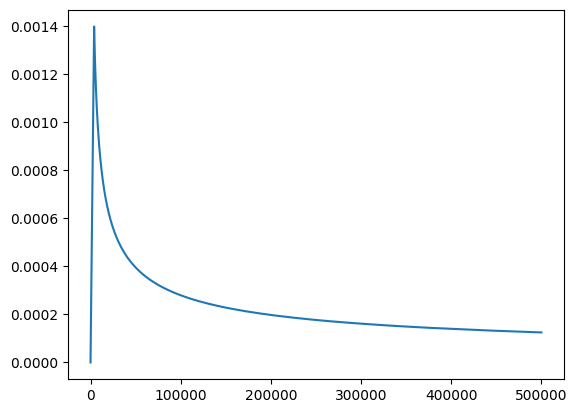

In [98]:
steps=500000

plt.plot(learning_rate(range(steps)))

In [99]:
def masked_loss(true, pred):

    loss_func = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits = False, # softmax used
        reduction = 'none'
    )

    # mask to ignore padding in y_true
    mask = tf.cast(tf.logical_not(tf.equal(true, 0)), loss_func.dtype)

    loss = loss_func(true, pred)

    # apply mask
    loss *= mask

    return tf.reduce_sum(loss, axis = -1) / tf.reduce_sum(mask , axis=-1)

train_loss = tf.keras.metrics.Mean(name = 'train_loss')

losses = []

In [100]:
@tf.function
def train_step(model, input, target):

    """custom training function alternative to using model.compile() and model.fit(),
        but with added extra flexibility."""

    # prepair target
    tar_inp = target[:, :-1] # input target wothout EOS
    tar_real = target[:, 1:] # actual target without SOS

    # maskes
    enc_padding_mask = create_padding_mask(input)
    dec_padding_mask = create_padding_mask(input)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar_inp)[1]) # target seq_len

    # TensorFlow starts recording all operations that involve tensors
    with tf.GradientTape() as tape:

        # Forward Pass
        predictions = model(
            input,
            tar_inp,
            is_training=True,
            enc_padding_mask = enc_padding_mask,
            dec_padding_mask = dec_padding_mask,
            look_ahead_mask = look_ahead_mask
        )

        # loss
        loss = masked_loss(tar_real, predictions)

    # After the block ends, use tape.gradient() to automatically compute gradients
    gradient = tape.gradient(loss, model.trainable_variables)

    # update parameters
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))

    # update loss
    train_loss(loss)

In [102]:
train_step(transformer, list(dataset.take(1))[0][0], list(dataset.take(1))[0][1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'encoder_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


#Summarization


In [103]:
def next_word(model, encoder_input, output):

    "A function for predicting the next word in the summary"

    # used in encoder multi head attention layer
    enc_padding_mask = create_padding_mask(encoder_input)

    # used in decoder masked multi head attention layer
    look_ahead_mask = create_look_ahead_mask(tf.shape(output)[1])

    # used in decoder multi head attention layer
    # we need to pad the encoder positions that comes from the encoder
    dec_padding_mask = create_padding_mask(encoder_input)

    predictions = model(
        encoder_input,
        output,
        is_training = False,
        enc_padding_mask = enc_padding_mask,
        dec_padding_mask = dec_padding_mask,
        look_ahead_mask = look_ahead_mask)

    # select the hidden state for the last token
    predictions = predictions[:, -1:, :]

    predicted_id = tf.cast(tf.argmax(predictions ,axis = -1), tf.int32)

    return predicted_id

In [104]:
input_document = tokenizer.texts_to_sequences(["see you"])
input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')
encoder_input = tf.expand_dims(input_document[0], 0)

output = tf.expand_dims([tokenizer.word_index["[SOS]"]], 0)

predicted_token = next_word(transformer, encoder_input, output)
print(f"Predicted token: {predicted_token}")

predicted_word = tokenizer.sequences_to_texts(predicted_token.numpy())[0]
print(f"Predicted word: {predicted_word}")

Predicted token: [[30039]]
Predicted word: puh


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [106]:
def summarize(model, input_document, decoder_maxlen):

    "A function for summarization using the transformer model"

    input_document = tokenizer.texts_to_sequences([input_document])

    input_document = tf.keras.preprocessing.sequence.pad_sequences(
        input_document,
        maxlen = encoder_maxlen,
        padding = 'post',
        truncating = 'post'
    )

    encoder_input = tf.expand_dims(input_document[0], 0)

    output = tf.expand_dims([tokenizer.word_index["[SOS]"]], 0)

    for i in range(decoder_maxlen):

        predicted_id = next_word(model, encoder_input, output)
        output = tf.concat([output, predicted_id], axis=-1)

        if predicted_id == tokenizer.word_index["[EOS]"]:
            break

    return tokenizer.sequences_to_texts(output.numpy())[0]

In [107]:
training_set_example = 0

# Check a summary of a document from the training set
print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
summarize(transformer, document[training_set_example], decoder_maxlen)

Training set example:
[SOS] amanda: i baked cookies. do you want some? jerry: sure! amanda: i'll bring you tomorrow :-) [EOS]

Human written summary:
[SOS] amanda baked cookies and will bring jerry some tomorrow. [EOS]

Model written summary:


"[SOS] puh promptly terminates gr8 frittur ozan laaaast stapler loooong birthady flavoured towns shocks cleaners leonard's primal birthady ozan valentines maintains pigment morality decade decade kawasaki case floor extra determination determination determination cartman moldova kendrick robinson ddi chris'es robinson isn’t sloooow counseling determination waits waits aaaa assesment wirelessly valentines dilan convesation"

#Train the model

In [108]:
epochs = 20
number_of_batches = len(list(dataset))

test_example = 0
true_summary = summary_test[test_example]
true_document = document_test[test_example]

for epoch in range(epochs):

    start = time.time()
    train_loss.reset_state()

    for batch, (inp, tar) in enumerate(dataset):

        train_step(transformer, inp, tar)

    print (f'Epoch {epoch + 1}, Loss {train_loss.result():.4f}')

    losses.append(train_loss.result())

    print (f'Time taken for one epoch: {time.time() - start} sec')
    print('Example summarization on the test set:')
    print('  True summarization:')
    print(f'    {true_summary}')
    print('  Predicted summarization:')
    print(f'    {summarize(transformer, true_document, decoder_maxlen)}\n')

Epoch 1, Loss 9.9260
Time taken for one epoch: 32.32589292526245 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] [EOS]

Epoch 2, Loss 7.7242
Time taken for one epoch: 27.580942630767822 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] [EOS]

Epoch 3, Loss 6.6189
Time taken for one epoch: 27.253843545913696 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] is going to the [EOS]

Epoch 4, Loss 5.9556
Time taken for one epoch: 27.101184844970703 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty'

Text(0.5, 0, 'Epoch')

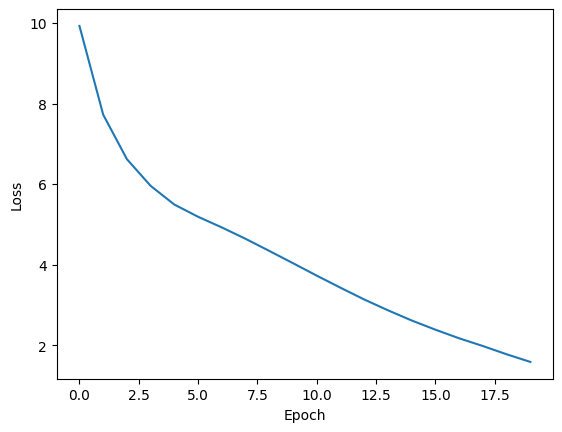

In [109]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [112]:
save_dir = "model.weights.h5"

In [113]:
# transformer.save_weights(save_dir)

In [114]:
transformer.load_weights(save_dir)

In [129]:
training_set_example = 41

# Check a summary of a document from the training set
print('Training set example:')
print(document_test[training_set_example])
print('\nHuman written summary:')
print(summary_test[training_set_example])
print('\nModel written summary:')
print(summarize(transformer, document_test[training_set_example], decoder_maxlen))

Training set example:
[SOS] frank: son, will you come home this weekend? son: not sure yet. something happened? frank: of course not. your mother miss you. son: i miss her too. frank: so will you com? son: i will try. frank: good, i will tell your mother that you will come son: oh, dad.. ok i will come. [EOS]

Human written summary:
[SOS] son is coming to see his parents' this weekend. [EOS]

Model written summary:
[SOS] frank will come home to visit his mother [EOS]
